In [1]:
#importing dependencies
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import linregress
import requests
import json
from pprint import pprint
from datetime import datetime
import numpy as np

# Setting path to import Csv files.
auto_insurance_to_load = Path("Resources/AutoInsurance.csv")

# Reading CSV files and transforming into Dataframe.
auto_insurance_df = pd.read_csv(auto_insurance_to_load)

# set the API URL. 
url_cali = "https://crashviewer.nhtsa.dot.gov/CrashAPI/crashes/GetCaseList?states=6&fromYear=2011&toYear=2011&minNumOfVehicles=1&maxNumOfVehicles=6&format=json"
url_ariz = "https://crashviewer.nhtsa.dot.gov/CrashAPI/crashes/GetCaseList?states=4&fromYear=2011&toYear=2011&minNumOfVehicles=1&maxNumOfVehicles=6&format=json"
url_wash = "https://crashviewer.nhtsa.dot.gov/CrashAPI/crashes/GetCaseList?states=53&fromYear=2011&toYear=2011&minNumOfVehicles=1&maxNumOfVehicles=6&format=json"
url_ore = "https://crashviewer.nhtsa.dot.gov/CrashAPI/crashes/GetCaseList?states=41&fromYear=2011&toYear=2011&minNumOfVehicles=1&maxNumOfVehicles=6&format=json"
url_nev = "https://crashviewer.nhtsa.dot.gov/CrashAPI/crashes/GetCaseList?states=32&fromYear=2011&toYear=2011&minNumOfVehicles=1&maxNumOfVehicles=6&format=json"

In [2]:
# Extracting data from Json file. 
response = requests.get(url_cali).json()
response_one = requests.get(url_ariz).json()
response_two = requests.get(url_nev).json()
response_three =  requests.get(url_wash).json()
response_four =  requests.get(url_ore).json()

In [3]:
#filtering data which is required for our analysis.
data = response['Results'][0]
data_one = response_one['Results'][0]
data_two = response_two['Results'][0]
data_three = response_three['Results'][0]
data_four = response_four['Results'][0]

In [4]:
# Convert the cities accident data into a Pandas DataFrame
cali_df = pd.DataFrame(data)
ariz_df = pd.DataFrame(data_one)
nev_df = pd.DataFrame(data_two)
wash_df = pd.DataFrame(data_three)
ore_df = pd.DataFrame(data_four)

In [5]:
#combined all states accident data into one dataframe. 
combined_df = pd.concat([cali_df, ariz_df, nev_df, wash_df, ore_df], ignore_index=True)
combined_df.sample(10)

,CountyName,CrashDate,Fatals,Peds,Persons,St_Case,State,StateName,TotalVehicles
401,STANISLAUS (99),/Date(1299935340000-0500)/,1,0,3,60403,6,California,2
2586,LOS ANGELES (37),/Date(1320144660000-0400)/,1,1,1,62593,6,California,1
3033,COCONINO (5),/Date(1313423700000-0400)/,1,0,2,40430,4,Arizona,1
453,SONOMA (97),/Date(1301103600000-0400)/,1,1,1,60455,6,California,1
916,MONTEREY (53),/Date(1307255400000-0400)/,1,0,1,60920,6,California,1
2314,SAN DIEGO (73),/Date(1324375080000-0500)/,1,0,1,62321,6,California,1
187,SAN BERNARDINO (71),/Date(1296435060000-0500)/,1,1,2,60189,6,California,1
2940,PINAL (21),/Date(1309716120000-0400)/,1,0,2,40335,4,Arizona,1
3550,NYE (23),/Date(1320106800000-0400)/,1,0,4,320186,32,Nevada,2
1856,SAN DIEGO (73),/Date(1318089000000-0400)/,1,0,5,61862,6,California,5


In [8]:
# filtering the columns as per our need for analysis. 
unclean_auto_df =  auto_insurance_df[[
                            "State",
                            "Gender",
                            "Coverage",
                            "Education",
                            "Income",
                            "Number of Policies",
                            "Marital Status",
                            "EmploymentStatus",
                            "Policy Type",
                            "Policy",
                            "Renew Offer Type",
                            "Monthly Premium Auto",
                            "Total Claim Amount",
                            "Vehicle Class", 
                            "Vehicle Size",
                            "Customer Lifetime Value"
                            ]]
# deleting first row as it did not have relevant information.
auto_df = unclean_auto_df.drop(index=0)
# removing all rows where income = 0 to clean the dataframe.
income_df = auto_df.loc[auto_df["Income"] != 0]

# checking the correlation between different elements on the dataframe.
income_df[["Income","Monthly Premium Auto","Customer Lifetime Value","Total Claim Amount","Number of Policies",]].corr()

,Income,Monthly Premium Auto,Customer Lifetime Value,Total Claim Amount,Number of Policies
Income,1.000000,-0.012372,0.002915,-0.221879,-0.001324
Monthly Premium Auto,-0.012372,1.000000,0.399491,0.636084,-0.026795
Customer Lifetime Value,0.002915,0.399491,1.000000,0.245464,0.022683
Total Claim Amount,-0.221879,0.636084,0.245464,1.000000,-0.012253
Number of Policies,-0.001324,-0.026795,0.022683,-0.012253,1.000000


Q -- Is there correlation between Total Claim amount/Customer Lifetime Value versus Monthly premiums? If so, is it strong enough to create a prediction model?

In [14]:
# Defined function for linear regression and scatter plot
def linear_regression(x_values, y_values):
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    return print(f"The R-value is {rvalue**2}"),plt.scatter(x_values,y_values,color="gold",edgecolors="black",alpha=0.3),plt.plot(x_values,regress_values,"b-"),plt.annotate(line_eq,(min(x_values) + 50,max(y_values)),fontsize=10,color="red")

The R-value is 0.1595930222935034


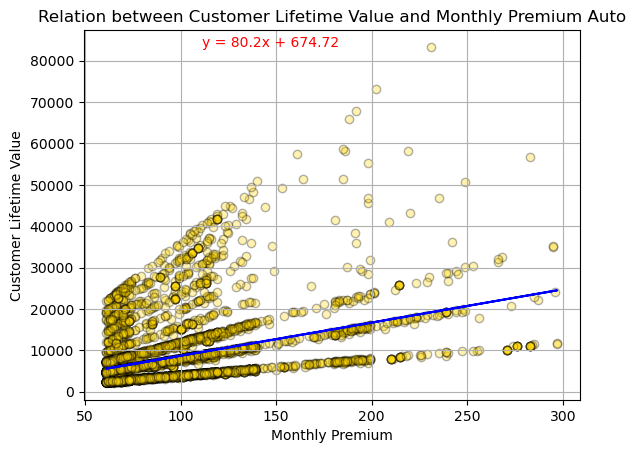

In [15]:
# defining variables to put into function
x_values = income_df["Monthly Premium Auto"]
y_values = income_df["Customer Lifetime Value"]
linear_regression(x_values,y_values)

# adding plot specific detail that cant be dynamic using function.
plt.xlabel("Monthly Premium")
plt.ylabel("Customer Lifetime Value")
plt.title("Relation between Customer Lifetime Value and Monthly Premium Auto")
plt.grid(True)
plt.savefig("Output/Scatter1.png")

The R-value is 0.4046024951347791


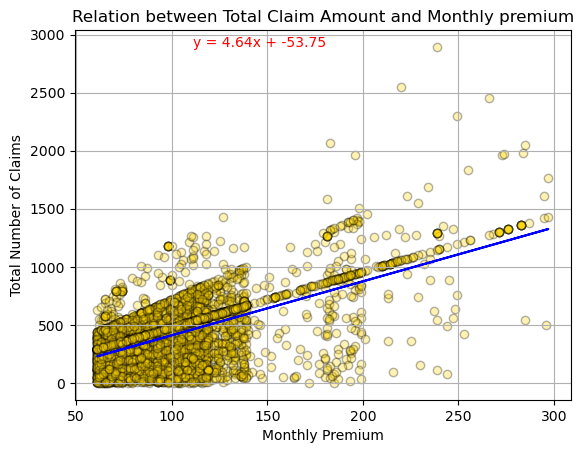

In [16]:
# defining variables to put into function
x_values = income_df["Monthly Premium Auto"]
y_values = income_df["Total Claim Amount"]
linear_regression(x_values,y_values,)
# adding plot specific detail that cant be dynamic using function.
plt.xlabel("Monthly Premium")
plt.ylabel("Total Number of Claims")
plt.title("Relation between Total Claim Amount and Monthly premium")
plt.grid(True)
plt.savefig("Output/Scatter2.png")

Written Analysis: 


The Relation between Customer Lifetime Value and Monthly Premiums is positive which indicates that a higher lifetime value tends to have a higher monthly Premium . The R-value of 0.1595 suggests that although the relation is positive there are possibly multiple other factors that could be impacting the monthly insurance premium. Therefore, in order to build a predictive model more data and advanced techniques would need to be implemented.

There is a positive corelation between Total Number of claims & Monthly Premium indicated by its R value of 0.4046. This may not indicate a highly predictive model but it still provides a significant amount of explanatory power. This model can be used to gain valuable insights, make informed decisions, and guide further improvements. Continuously refining the model and incorporating more data and advanced techniques can help enhance its predictive capabilities. This model can be a good starting point but would need more sophistication to be accurate in its prediction.